In [20]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["FL_to_SRI_brain", "T1_to_SRI_brain", "T1CE_to_SRI_brain", "T2_to_SRI_brain"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    d_out = os.path.join( '/', d.split("/")[1], d.split("/")[2], d.split("/")[3]  + '_train_GTV_brain_1cl')
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#     print('l')
#     print( os.path.join(d_out, example_id + ".nii.gz"))
    nibabel.save(vol, os.path.join(d_out, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, "check_gost_gtv_to_ref.nii.gz")):
#         print(os.path.join(d, "check_gost_gtv_to_ref.nii.gz"))
        seg = load_nifty(d, example_id, "check_gost_gtv_to_ref")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
#         print(os.path.join(d_out, example_id + "_seg.nii.gz"))
        nibabel.save(seg, os.path.join(d_out, example_id + "_seg.nii.gz"))


def prepare_dirs(data, train):
    d_out = os.path.join( '/', data.split("/")[1], data.split("/")[2], data.split("/")[3]  + '_train_GTV_brain_1cl')
    if not os.path.exists(d_out):
        call(f"mkdir {d_out}", shell=True)
    img_path, lbl_path = os.path.join(d_out, "images"), os.path.join(d_out, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(d_out, "*"))
    for d in dirs:
        if '.nii.gz' in d:
                if "FL_to_SRI_brain" in d or "T1_to_SRI_brain" in d or "T1CE_to_SRI_brain" in d or "T2_to_SRI_brain" in d:
                    continue
                if "_seg" in d:
                    call(f"mv {d} {lbl_path}", shell=True)
                else:
                    call(f"mv {d} {img_path}", shell=True)
                
#         call(f"rm -rf {d}", shell=True)
         

def prepare_dataset_json(data, train):
    d_out = os.path.join( '/', data.split("/")[1], data.split("/")[2], data.split("/")[3]  + '_train_GTV_brain_1cl')
    images, labels = glob(os.path.join(d_out, "images", "*")), glob(os.path.join(d_out, "labels", "*"))
    images = sorted([img.replace(d_out + "/", "") for img in images])
    labels = sorted([lbl.replace(d_out + "/", "") for lbl in labels])
    
    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"1": "gtv"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(d_out, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
#     run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "*"))))
    for each in sorted(glob(os.path.join(data, "*"))):
        if each.split('/')[-1] in ['604_17', '1332_17', '660_19', '789_15', '117_18_4', '79_18_4',
       '1360_18_4', '1440_17', '20_18_4', '1096_18', '1157_17', '601_17',
       '451_18_4', '171_18_4', '1646_18', '252_18_4', '1177_17',
       '1354_18_4', '1765_18_4', '17p_860', '59_18_4', '1467_17',
       '1575_17', '1028_18_4', '644_19_4', '1555_17', '423_19_4',
       '1391_17', '371_18_4', '135_19_4', '1484_18_4', '1734_18', '269_19_4', '281_19_4', 'Patient_1000114', 'Patient_1001616', 'Patient_110313', 'Patient_59817']:
            continue
        if os.path.exists(os.path.join(each, "check_gost_gtv_to_ref.nii.gz")):
            prepare_nifty(each)
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")


In [25]:
prepare_dataset('/data/private_data/brats_pipeline_out',True)

Preparing BraTS21 dataset from: /data/private_data/brats_pipeline_out
Preparing time: 669.93


###### !python3 ../preprocess.py --data /data/private_data/ --task 16 --ohe --exec_mode training --results /data/private_data

In [24]:
!cd /data/private_data && rm -r 16_3d

In [2]:
import torch
ch= torch.load('/results/glioma_results/brain_right_label/fold-2/checkpoints/last.ckpt')

In [2]:
for ech in ch:
    print(ech)

epoch
global_step
pytorch-lightning_version
state_dict
callbacks
optimizer_states
lr_schedulers
native_amp_scaling_state
hparams_name
hyper_parameters


In [3]:
ch['epoch']

110

In [ ]:
!export CUDA_VISIBLE_DEVICES=1 && python ../main.py --data /data/private_data/15_3d --results /results/glioma_results/brain_right_label/fold-1 --resume_training  --ckpt_path /results/glioma_results/brain_right_label/fold-1/checkpoints --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --scheduler --learning_rate 0.0003 --epochs 150 --nfolds 3 --fold 1 --amp --gpus 1 --task 15 --save_ckpt

Global seed set to 1
185 training, 92 validation, 277 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type    | Params
----------------------------------
0 | model | DynUNet | 50.8 M
1 | loss  | Loss    | 0     
2 | dice  | Dice    | 0     
----------------------------------
50.8 M    Trainable params
0         Non-trainable params
50.8 M    Total params
203.360   Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/callback_hook.py:307: LightningDeprecationWarning: `Callback.on_load_checkpoint` signature has changed in v1.3. `trainer` and `pl_module` parameters have been added. Support for the old s

In [4]:
!nvidia-smi

Sat Jan 22 21:21:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:21:01.0 Off |                    0 |
| N/A   55C    P0   272W / 250W |  18316MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:21:02.0 Off |                    0 |
| N/A   

In [10]:
! cd /results/glioma_infer &&  ls

fold-0_brats  fold-0_brats_brain  fold-1_brats_brain  fold-2_brats_brain


In [11]:
!cd ../ && export CUDA_VISIBLE_DEVICES=0 && python main.py --brats --exec_mode predict --task 15 --data /data/private_data/15_3d --dim 3 --fold 2 --nfolds 3 --ckpt_path /results/glioma_results/brain_right_label/fold-2/checkpoints/epoch=91-dice_mean=74.90.ckpt --results /results/glioma_infer/fold-2_brats_brain --amp --tta --save_preds

Global seed set to 1
0 training, 0 validation, 277 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
[0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing: 100%|████████████████████████████████| 277/277 [24:43<00:00,  5.36s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [14]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_1', 'Dice_2', 
                'Hausdorff95_1', 'Hausdorff95_2',
               'Sensitivity_1', 'Sensitivity_2',
                'Specificity_1', 'Specificity_2',
                'Surface_dice_1', 'Surface_dice_2',
               'Precision_1', 'Precision_2']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==0), (pred_mask[1,:,:,:]==0), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==0), (pred_mask[1,:,:,:]==0))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==0), (pred_mask[1,:,:,:]==0))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
#     distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
#     df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
#     df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
#     sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Sensitivity_4'] = sens
#     df.at[0,'Precision_4'] = precision
#     df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_1', 'Dice_2',
               'Hausdorff95_1', 'Hausdorff95_2',
               'Sensitivity_1', 'Sensitivity_2',
                'Specificity_1', 'Specificity_2',
                'Surface_dice_1', 'Surface_dice_2',
                'Precision_1', 'Precision_2']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    label = os.listdir(target_folder)
    label = [l.split('/')[-1][:-11] for l in label]
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        if sub in label:
            targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        
            predictions = np.load((os.path.join(path_pred, ids)))
            spaces = [1,1,1]
            pred = np.round(predictions, 0)
            pred = np.transpose(pred, (0, 3, 2, 1))
    #         print(targets.shape), print(pred.shape)
    #         print(np.unique(targets)), print(np.unique(pred))
            df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
    #         print(df)
            af_all = af_all.append(df)
        else:
            continue
    af_all.to_csv('all_metris_glioma_right_label_fold2.csv')  
    print(af_all.mean())

In [13]:
!cd /results/glioma_infer/fold-2_brats_brain/ && ls

'predictions_epoch=91-dice_mean=74_90_task=15_fold=2_tta'


In [15]:

path_pred='/results/glioma_infer/fold-2_brats_brain/predictions_epoch=91-dice_mean=74_90_task=15_fold=2_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

100%|██████████| 277/277 [19:10<00:00,  4.15s/it]

Dice_1               0.998404
Dice_2               0.794126
Hausdorff95_1        0.505017
Hausdorff95_2       11.692717
Sensitivity_1        0.998516
Sensitivity_2        0.802759
Specificity_1        0.802759
Specificity_2        0.998516
Surface_dice_1       0.976518
Surface_dice_2       0.492283
Precision_1          0.998295
Precision_2          0.821268
Dice_all                  NaN
Dice_0                    NaN
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_4               NaN
dtype: float64


In [19]:
ch = pd.read_csv('all_metris_glioma_right_label.csv')
ch.mean()

Unnamed: 0           0.000000
Dice_all                  NaN
Dice_0                    NaN
Dice_1               0.998404
Dice_2               0.798849
Dice_3                    NaN
Hausdorff95_all           NaN
Hausdorff95_0             NaN
Hausdorff95_1        0.545971
Hausdorff95_2       10.282661
Hausdorff95_4             NaN
Sensitivity_all           NaN
Sensitivity_0             NaN
Sensitivity_1        0.998479
Sensitivity_2        0.818275
Sensitivity_4             NaN
Specificity_all           NaN
Specificity_0             NaN
Specificity_1        0.818275
Specificity_2        0.998479
Specificity_4             NaN
Surface_dice_all          NaN
Surface_dice_0            NaN
Surface_dice_1       0.976649
Surface_dice_2       0.494878
Surface_dice_4            NaN
Precision_all             NaN
Precision_0               NaN
Precision_1          0.998332
Precision_2          0.811396
Precision_4               NaN
dtype: float64

1019_18
(4, 3)
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


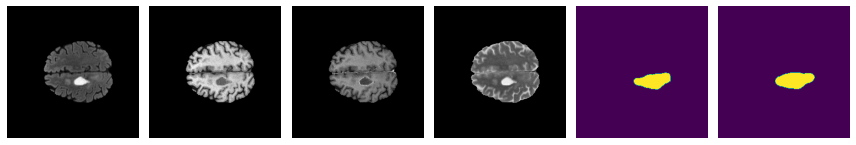

102_19_4
(4, 3)
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


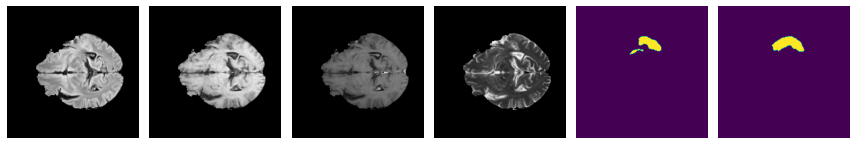

1032_19
(4, 3)
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


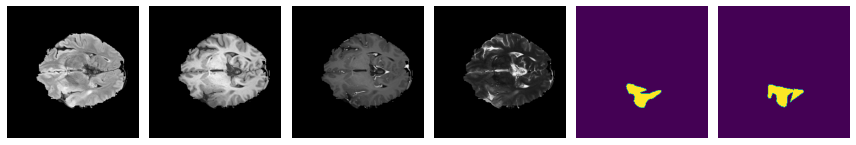

1034_18_4
(4, 3)
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


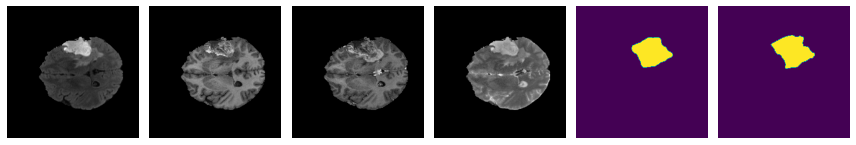

1036_18
(4, 3)
(240, 240)
(240, 240, 155, 2)
[0. 1.]
[0 1]


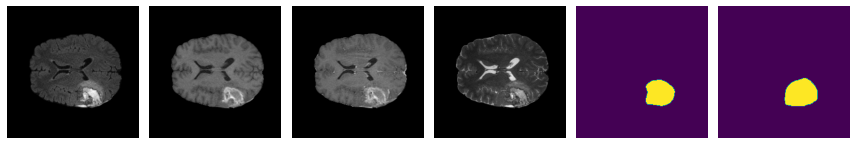

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 110
data = sorted(glob("/results/glioma_infer/fold-0_brats_brain/check/predictions_epoch=89-dice_mean=75_98_task=15_fold=0_tta/*.npy"))
for i, z in zip([0,2,3,4,5,6],[110,65,65,65, 80]):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    meta = np.load(f'/data/private_data/15_3d/{fname}_meta.npy')
#     print(meta)
#     meta = np.load(f'/data/private_data/15_3d/{fname}_x.npy')
    print(meta.shape)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
#     pred = to_lbl(np.round(pred, 0))[:, :, z]
    pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 1, 2, 3]] + [pred[:, :, z, 1]] + [label]
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 12))
    for i in range(6):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [ ]:
final_pred = np.zeros((n_class, *original_shape))
final_pred[:, min_d:max_d, min_h:max_h, min_w:max_w] = pred  

In [3]:
meta

array([[  0,  39,  48],
       [141, 217, 189],
       [155, 240, 240],
       [141, 178, 141]])

In [38]:
!nvidia-smi

Wed Jan 19 14:29:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:21:01.0 Off |                    0 |
| N/A   48C    P0    44W / 250W |  25523MiB / 32510MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:21:02.0 Off |                    0 |
| N/A   

In [35]:
#Surface DICE с трешхолдами 1,2,3.
import pandas as pd
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 
                'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3']
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,2)
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,3)
    return df
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
        predictions = np.load((os.path.join(path_pred, ids)))
        spaces = [1,1,1]
        pred = np.round(predictions, 0)
        pred = np.transpose(pred, (0, 3, 2, 1))
    #         print(targets.shape), print(pred.shape)
    #         print(np.unique(targets)), print(np.unique(pred))
        df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
    #         print(df)
        af_all = af_all.append(df)
    af_all.to_csv('SurfaceDICE_1,2,3_fold2.csv')  
    print(af_all.mean())

In [37]:
path_pred='/results/glioma_infer/fold-2_brats_brain/predictions_epoch=91-dice_mean=74_90_task=15_fold=2_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [12:07<00:00,  2.63s/it]

Surface_dice_1    0.492283
Surface_dice_2    0.657622
Surface_dice_3    0.779564
dtype: float64


In [1]:
!cd /results/glioma_infer && ls

OSError: [Errno 12] Cannot allocate memory

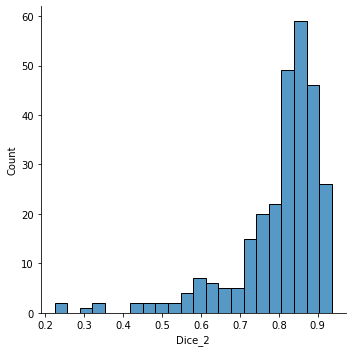

In [38]:
import seaborn as sns
df = pd.read_csv('all_metris_glioma_right_label.csv')
sns.displot(df.Dice_2);

In [2]:
#PR кривые
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 
'Sensitivity_0.0' ,'Sensitivity_0.1', 'Sensitivity_0.2','Sensitivity_0.3', 'Sensitivity_0.4', 'Sensitivity_0.5', 'Sensitivity_0.6', 'Sensitivity_0.7', 'Sensitivity_0.8', 'Sensitivity_0.9', 'Sensitivity_1.0',
'Precision_0.0', 'Precision_0.1', 'Precision_0.2', 'Precision_0.3', 'Precision_0.4', 'Precision_0.5', 'Precision_0.6', 'Precision_0.7', 'Precision_0.8', 'Precision_0.9', 'Precision_1.0']
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    threshold = np.linspace(0.0, 1.0, num=11)
    for th in threshold:
        th = np.round(th, 2)
        pred = (pred_mask > th).astype(np.int)
        pred = np.transpose(pred, (0, 3, 2, 1))
        #class 2
        sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred[1,:,:,:]==1))
        df.at[0,f'Sensitivity_{th}'] = sens
        df.at[0,f'Precision_{th}'] = precision
    prediction = np.round(pred_mask, 0)
    prediction = np.transpose(prediction, (0, 3, 2, 1))
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (prediction[1,:,:,:]==1))
    return df

    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 
'Sensitivity_0.0' ,'Sensitivity_0.1', 'Sensitivity_0.2','Sensitivity_0.3', 'Sensitivity_0.4', 'Sensitivity_0.5', 'Sensitivity_0.6', 'Sensitivity_0.7', 'Sensitivity_0.8', 'Sensitivity_0.9', 'Sensitivity_1.0',
'Precision_0.0', 'Precision_0.1', 'Precision_0.2', 'Precision_0.3', 'Precision_0.4', 'Precision_0.5', 'Precision_0.6', 'Precision_0.7', 'Precision_0.8', 'Precision_0.9', 'Precision_1.0']

    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
        predictions = np.load((os.path.join(path_pred, ids)))
        spaces = [1,1,1]
#             pred = np.round(predictions, 0)
#             pred = np.transpose(pred, (0, 3, 2, 1))
        df=calculate_metrics_brats(targets.astype('int'), predictions, sub, spaces)
        af_all = af_all.append(df)
    af_all.to_csv('pr_curve_fold0.csv')  
    print(af_all.mean())

In [3]:
path_pred='/results/glioma_infer/fold-0_brats_brain/predictions_epoch=89-dice_mean=75_98_task=15_fold=0_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

  0%|                                                                                                               | 0/277 [00:00<?, ?it/s]/tmp/ipykernel_2043/1788834452.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = (pred_mask > th).astype(np.int)
/tmp/ipykernel_2043/1788834452.py:24: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [11:43<00:00,  2.54s/it]

Sensitivity_0.0    1.000000
Sensitivity_0.1    0.882654
Sensitivity_0.2    0.859651
Sensitivity_0.3    0.844180
Sensitivity_0.4    0.831086
Sensitivity_0.5    0.818275
Sensitivity_0.6    0.805010
Sensitivity_0.7    0.789507
Sensitivity_0.8    0.768505
Sensitivity_0.9    0.728706
Sensitivity_1.0    0.000000
Precision_0.0      0.008522
Precision_0.1      0.011525
Precision_0.2      0.011213
Precision_0.3      0.011004
Precision_0.4      0.010827
Precision_0.5      0.811396
Precision_0.6      0.822947
Precision_0.7      0.835202
Precision_0.8      0.850095
Precision_0.9      0.873463
Precision_1.0           NaN
dtype: float64


In [6]:
pr = pd.read_csv('pr_curve_fold0.csv')
pr_mean = pr.mean()
rec = []
prec = []
threshold = np.linspace(0.0, 0.9, num=10)
print(threshold)
for th in threshold:
        th = np.round(th, 2)
        rec.append(pr_mean[f'Sensitivity_{th}'])
        prec.append(pr_mean[f'Precision_{th}'])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [9]:
rec

[1.0,
 0.882653922634353,
 0.859651064636931,
 0.8441802619611083,
 0.8310862203545218,
 0.8182750399215332,
 0.805010488132394,
 0.7895067593335833,
 0.7685052679793337,
 0.7287055228778666]

In [10]:
prec

[0.008521868085477998,
 0.011525139864099572,
 0.011213274577580371,
 0.011004196216646717,
 0.010827384926910122,
 0.8113962544333281,
 0.8229469289277687,
 0.8352018551116656,
 0.8500948383454691,
 0.8734633010231038]

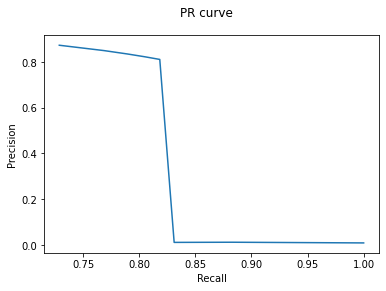

In [12]:
import matplotlib.pyplot as plt
plt.plot(rec,prec)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.suptitle('PR curve')
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference



    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm

 
_columns = ['Ids', 'Volume']
tumor_volume = pd.DataFrame(columns = _columns)
data = sorted(glob("/data/private_data/brats_pipeline_out_train_GTV_brain/labels/*_seg.nii.gz"))
for i in tqdm(range(len(data))):
    label = nib.load(data[i]).get_fdata().astype(np.uint8)
    sub = data[i].split('/')[-1][:-11]
#     print(sub)
    vox_size = 1
    get_tumor_volume=np.sum(label>0)*(vox_size**3)
    tumor_volume.at[i,'Ids'] = sub
    tumor_volume.at[i,'Volume'] = get_tumor_volume
    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:35<00:00,  7.81it/s]


In [32]:
metrics= pd.read_csv('all_metris_glioma_right_label.csv')
pr_rec = metrics[['Precision_2', 'Sensitivity_2', 'Ids']]
bland_altman_df = pr_rec.merge(tumor_volume, on='Ids',  how='left')

In [40]:
# bland_altman_df.to_csv('bland_altman_plot.csv')

In [48]:
bland_altman_df.Volume.min()

5243

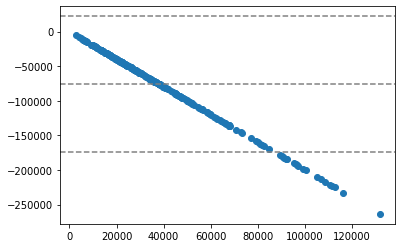

In [41]:
bland_altman_plot(bland_altman_df['Precision_2'].values,bland_altman_df['Volume'].values)

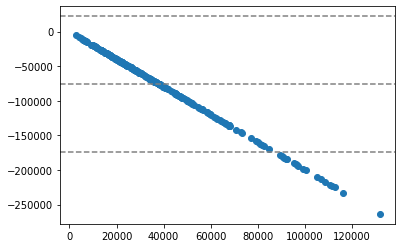

In [42]:
bland_altman_plot(bland_altman_df['Sensitivity_2'].values,bland_altman_df['Volume'].values)

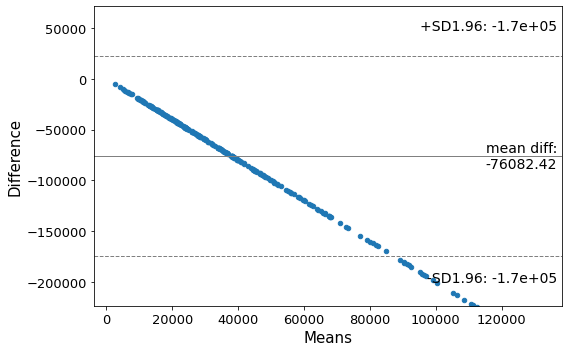

In [45]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(bland_altman_df['Sensitivity_2'].values, bland_altman_df['Volume'].values, ax = ax)
plt.show()

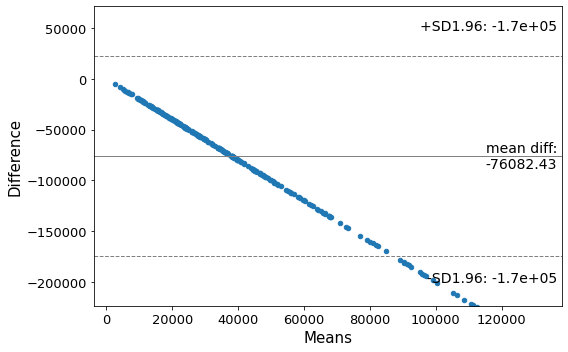

In [46]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(bland_altman_df['Precision_2'].values, bland_altman_df['Volume'].values, ax = ax)
plt.show()

In [49]:
dice_metrics= metrics[['Dice_2','Ids']]

In [53]:
dice_metrics[dice_metrics['Dice_2']<0.7].Ids.values


array(['Patient_102016', 'Patient_73415', 'Patient_63916',
       'Patient_56716', '1295_18_4', 'Patient_2317', 'Patient_83314',
       'Patient_61017', 'Patient_41117', '1788_18_4', 'Patient_127016',
       'Patient_24717', 'Patient_84917', '1345_19_4', '1776_18_4',
       '1112_19_4', '75_19', 'Patient_15215', 'Patient_104316',
       'Patient_133916', 'Patient_115615', '705_18_4', '8_19', '195_19_4',
       '1229_19_4', '831_19_4', '634_19_4', 'Patient_80117',
       'Patient_90014', '1539_18', 'Patient_88917', '1184_18', '90_19',
       '575_18_4', '1566_18', '1743_18_4', '1170_18_4', '17_19_'],
      dtype=object)

In [5]:
import numpy as np
fname = '1019_18'
img = np.load(f"/data/private_data/15_3d/{fname}_x.npy").astype(np.float32)
label = np.load(f"/data/private_data/15_3d/{fname}_y.npy").astype(np.uint8)
meta =  np.load(f"/data/private_data/15_3d/{fname}_meta.npy").astype(np.uint8)
orig_lbl =  np.load(f"/data/private_data/15_3d/{fname}_orig_lbl.npy").astype(np.uint8)

In [6]:
img.shape, label.shape, meta.shape, orig_lbl.shape

((5, 140, 159, 142), (1, 140, 159, 142), (4, 3), (1, 140, 159, 142))

In [7]:
meta

array([[  0,  51,  49],
       [140, 210, 191],
       [155, 240, 240],
       [140, 159, 142]], dtype=uint8)

In [9]:
import nibabel as nib
img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/images/{fname}.nii.gz").get_fdata().astype(np.float32)
label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)

In [10]:
img.shape, label.shape

((240, 240, 155, 4), (240, 240, 155))

1019_18
(2, 155, 240, 240)
(142, 159, 140, 1)
(142, 159, 140, 5)
(240, 240, 155, 2)


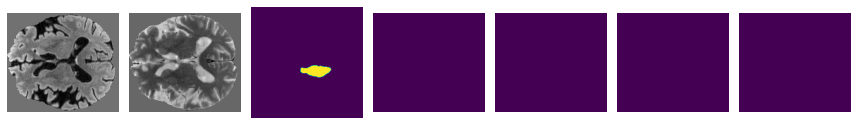

1029_18_4
(2, 155, 240, 240)
(133, 177, 134, 1)
(133, 177, 134, 5)
(240, 240, 155, 2)


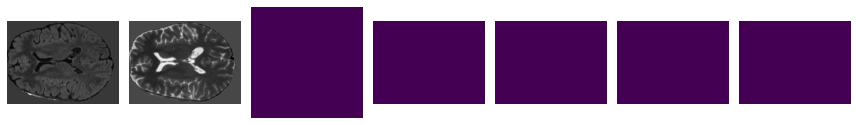

102_19_4
(2, 155, 240, 240)
(141, 170, 137, 1)
(141, 170, 137, 5)
(240, 240, 155, 2)


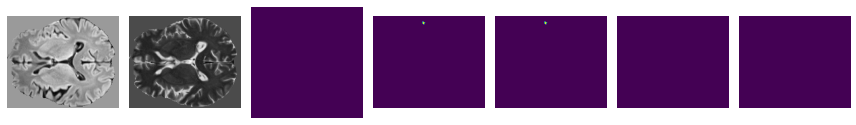

1032_19
(2, 155, 240, 240)
(138, 173, 129, 1)
(138, 173, 129, 5)
(240, 240, 155, 2)


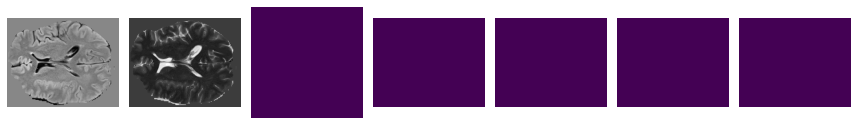

1034_18_4
(2, 155, 240, 240)
(143, 159, 141, 1)
(143, 159, 141, 5)
(240, 240, 155, 2)


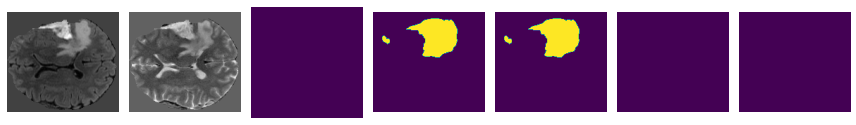

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 105
data = sorted(glob("/results/glioma_infer/fold-0_brats_brain/predictions_epoch=89-dice_mean=75_98_task=15_fold=0_tta/*.npy"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = np.load(f"/data/private_data/15_3d/{fname}_x.npy").astype(np.float32).transpose(3,2,1,0)
    label = np.load(f"/data/private_data/15_3d/{fname}_y.npy").astype(np.uint8).transpose(3,2,1,0)
    pred = np.load(data[i])
    print(pred.shape), print(label.shape), print(img.shape)
#     p = to_lbl(np.round(pred, 0))
    p = np.round(pred, 0).transpose(3,2,1,0)
    print(p.shape)
    imgs = [img[:, :, l, i] for i in [0, 3]] + [p[:, :, z,1]] + [label[:,:, l, 0]]+  [label[:, :, l, 0]==1] +  [label[:, :, l, 0]==2] +  [label[:, :, l, 0]==3] 
    
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    for i in range(7):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()